The CDC collects data yearly on American health through the National Health Interview Survey (NHIS). This survey contains ten's of thousands of records each year across about a hundred questions relating to the health of people. While the most recent data is unavailable to the public, a few years back the majority of it is accessable here https://www.cdc.gov/nchs/nhis/index.htm. While this data is theoretically useful, not much has been done with it because it is unwieldy and difficult to work with. Rather than trying to use a large amount of it, the goal of this project is to predict some or all of the 9 questions relating to food. Some of them are binary, "Could you afford to eat balanced meals" and some are more complexe "In the last week how many days did you not eat". Using this data can be used to locate where food aid needs to be sent, or what indicators imply a difficult life for students.  

In [2]:
import tensorflow as tf
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt

The NHIS data is distributed across a variety of files. The household file which contains some data related to the household. There is very little data here, the type of living quarters, which of the 4 regions in the US they are located in, or how many people in the household responded. The family file contains much better data, the target questions, questions about medical history, and questions about financial circumstances.

These two main files, and the other child and adult records can be combined through the Household Number identifier.

This is all data from the 2018 survey, the most recent to be released.

In [8]:
familydata = ps.read_csv('familyxxcsv/familyxx.csv')
#familydata
householddata = ps.read_csv('househldcsv/househld.csv')
#householddata
#These don't have the same number of columes, but can be merged on the HHX column, using default inner join
data = familydata.merge(householddata,on='HHX')
data

,FINT_Y_P,FINT_M_P,FMX,RECTYPE_x,SRVY_YR_x,HHX,FM_SIZE,FM_STRCP,FM_TYPE,FM_STRP,...,ACPT_FAM,NON_INTV,RECTYPE_y,SRVY_YR_y,LIVQRT_P,REGION,WTIA_HH,WTFA_HH,PSTRAT,PPSU
0,2018,1,1,60,2018,1,1,11,1,11,...,1.0,NaN,10,2018,1,3,2417.5,3338,103,19
1,2018,1,1,60,2018,4,3,41,4,41,...,1.0,NaN,10,2018,1,2,2347.5,5188,137,38
2,2018,2,1,60,2018,6,4,41,4,41,...,1.0,NaN,10,2018,1,3,2775.8,5259,106,22
3,2018,3,1,60,2018,8,3,41,4,41,...,1.0,NaN,10,2018,1,2,2689.2,3204,117,25
4,2018,2,1,60,2018,9,1,11,1,11,...,1.0,NaN,10,2018,1,3,3113.6,4497,126,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30304,2018,11,3,60,2018,55556,1,12,1,12,...,3.0,NaN,10,2018,1,2,3943.9,4470,147,37
30305,2018,11,1,60,2018,55557,1,11,1,11,...,1.0,NaN,10,2018,1,3,3964.5,7097,121,6
30306,2018,12,1,60,2018,55560,1,11,1,11,...,1.0,NaN,10,2018,1,3,4417.5,7835,130,23
30307,2018,10,1,60,2018,55562,2,21,2,21,...,1.0,NaN,10,2018,1,2,3950.2,6791,137,19


With 142 colums that contain actual data, there is way too much to just feed it all in. Ignoring the additional data that can be gathered from idividual records. So lets explore some some of the more plausible relations between some of the data.

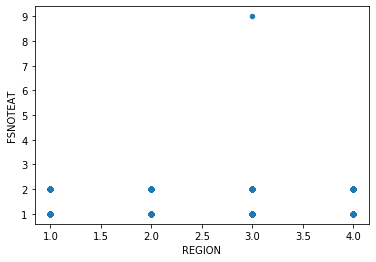

In [13]:
data.plot.scatter(x='REGION',y='FSNOTEAT')

This is a totally useless plot as there isn't enough detail in a single pair of columns

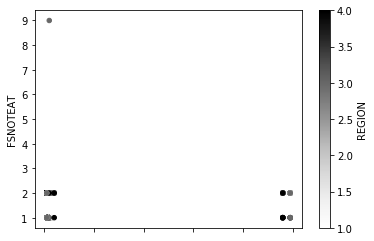

In [16]:
data.plot.scatter(x='INCGRP5',y='FSNOTEAT',c='REGION')

Even trying to include wealth into the picture, it doesn't substantially affect the results, beyond some additional variablity. This is why this data set is so hard to work with, and why extracting any sort of information from it has value, because it would allow the CDC to make some accuracte assessments of the situation.

FM_STRCP is a critical column, it describes what type of family is located in the household. It is a numerical value that represents a categorical thing, so some processing is required. That each of the codes means is decribed in the variable frequency data release.

Some of the data is irrelevant, what month the data was gathered or the given ID number both must be dropped as part of processing

In [10]:
familydata = ps.read_csv('familyxxcsv/familyxx.csv') #reload the family data set, so there is less overlap
familydata = familydata.drop(columns=['FINT_Y_P','FINT_M_P','FMX','RECTYPE','SRVY_YR','HHX'])#drop the identifying information
familydata = familydata.drop('WTFA_FAM',axis=1)#this is the weight of the family, ie how representative it is


In [11]:
familydata

,FM_SIZE,FM_STRCP,FM_TYPE,FM_STRP,TELN_FLG,CURWRKN,TELCELN,WRKCELN,PHONEUSE,FLNGINTV,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,1,11,1,11,1,1.0,1,1.0,3.0,1,...,NaN,1,2,2,NaN,2,1,1,NaN,NaN
1,3,41,4,41,1,2.0,1,3.0,NaN,1,...,4.0,2,1,1,1.0,2,3,1,2.0,3.0
2,4,41,4,41,1,2.0,1,2.0,NaN,1,...,1.0,2,2,2,NaN,1,4,1,2.0,4.0
3,3,41,4,41,1,2.0,1,2.0,NaN,1,...,3.0,3,2,1,NaN,2,3,1,2.0,3.0
4,1,11,1,11,1,2.0,1,1.0,NaN,1,...,NaN,2,1,1,1.0,2,1,1,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30304,1,12,1,12,1,2.0,1,1.0,NaN,1,...,1.0,1,2,2,NaN,2,1,1,NaN,1.0
30305,1,11,1,11,1,1.0,1,1.0,1.0,1,...,NaN,2,1,2,1.0,2,0,2,NaN,NaN
30306,1,11,1,11,1,2.0,1,1.0,NaN,1,...,4.0,5,1,1,2.0,2,1,1,2.0,1.0
30307,2,21,2,21,1,1.0,1,2.0,1.0,1,...,2.0,2,2,2,NaN,2,2,1,2.0,2.0


In [12]:
#an example of a randomforest https://medium.com/@dineshmadhup_75545/comparison-of-tensorflow-and-random-forest-model-with-python-92a475f84faa
from sklearn.model_selection import train_test_split
# Evaluations
from sklearn.metrics import classification_report,confusion_matrix
# Random Forest
from sklearn.ensemble import RandomForestClassifier

familydata.fillna(0,inplace=True)
#break off the possible goals
goals = ['FSRUNOUT','FSLAST','FSBALANC','FSSKIP','FSSKDAYS','FSLESS','FSHUNGRY','FSWEIGHT','FSNOTEAT','FSNEDAYS']
Y1 = familydata.filter(items=['FSLAST'])
Y2 = familydata.filter(items=['FSSKIP'])
Y3 = familydata.filter(items=['FSLESS'])
other = familydata.columns.tolist()
for col in goals:
    other.remove(col)
    

X = familydata.filter(items=other)
#find the other options


X_train, X_test, y_train, y_test = train_test_split(X,Y1)
#print(X_train, X_test, y_train, y_test)

In [72]:
rf_model = RandomForestClassifier(n_estimators=200)
#print(y_train)
rf_model.fit(X_train,y_train.values.ravel())
rf_prediction = rf_model.predict(X_test)
print(classification_report(y_test,rf_prediction))
print(confusion_matrix(y_test,rf_prediction))

              precision    recall  f1-score   support

           1       0.36      0.07      0.11       214
           2       0.36      0.07      0.11       578
           3       0.91      0.99      0.95      6783
           9       0.00      0.00      0.00         3

    accuracy                           0.89      7578
   macro avg       0.41      0.28      0.29      7578
weighted avg       0.85      0.89      0.86      7578

[[  14   26  174    0]
 [  13   39  526    0]
 [  12   44 6727    0]
 [   0    0    3    0]]


C:\tools\Anaconda3\envs\tensorflow_enc\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There are a few options that are so poorly represented they should not be used, those are 7,8, and 9. So that leaves the 3 common values, 1 often true, 2 sometimes true, and 3 never true. As can be seen, these values are very low, and unlikely to be an actually good way to extrac information from this data.

Looking at some easier to predict options, there is "Cut size or skipped meals because not enough money" or FSKDAYS Which is the number of days cut size or skipped meals. Eating less also has a much more reasonable split

In [75]:
#Estimator for FSSKIP
X_train, X_test, y_train, y_test = train_test_split(X,Y2)
rf_model = RandomForestClassifier(n_estimators=200)
#print(y_train)
rf_model.fit(X_train,y_train.values.ravel())
rf_prediction = rf_model.predict(X_test)
print(classification_report(y_test,rf_prediction))
print(confusion_matrix(y_test,rf_prediction))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      6412
         1.0       0.51      0.21      0.30       437
         2.0       0.33      0.07      0.11       729

    accuracy                           0.85      7578
   macro avg       0.57      0.42      0.45      7578
weighted avg       0.80      0.85      0.81      7578

[[6320   34   58]
 [ 303   93   41]
 [ 623   57   49]]


In [76]:
#Estimator for FSLESS
X_train, X_test, y_train, y_test = train_test_split(X,Y3)
rf_model = RandomForestClassifier(n_estimators=200)
#print(y_train)
rf_model.fit(X_train,y_train.values.ravel())
rf_prediction = rf_model.predict(X_test)
print(classification_report(y_test,rf_prediction))
print(confusion_matrix(y_test,rf_prediction))

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      6445
         1.0       0.45      0.23      0.30       424
         2.0       0.34      0.05      0.09       707
         7.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         1

    accuracy                           0.86      7578
   macro avg       0.33      0.25      0.26      7578
weighted avg       0.80      0.86      0.81      7578

[[6353   55   37    0    0]
 [ 294   96   34    0    0]
 [ 608   63   36    0    0]
 [   1    0    0    0    0]
 [   0    1    0    0    0]]


C:\tools\Anaconda3\envs\tensorflow_enc\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So after the simple random forest estimators, lets look at Neural Network classifiers since they are more likely to be able to actually use the multitude of variables to some effect. It is unlikely that this non-engineered data will actuall produce good results though.

In [114]:
#dropping the very race classes (7 and 9)
oddresults = familydata[ familydata['FSLESS'] >= 7.0].index
#nineres = familydata[ familydata['FSLESS'] == 9.0].index
cleaneddata = familydata.drop(oddresults)
#cleaneddata = familydata.drop(nineres)
Y4 = cleaneddata.filter(items=['FSLESS'])
X4 = cleaneddata.filter(items=other)
print(Y4.FSLESS.unique())

#Estimator for FSLESS
X_train, X_test, y_train, y_test = train_test_split(X4,Y4)
rf_model = RandomForestClassifier(n_estimators=200)
#print(y_train)
rf_model.fit(X_train,y_train.values.ravel())
rf_prediction = rf_model.predict(X_test)
print(classification_report(y_test,rf_prediction))
print(confusion_matrix(y_test,rf_prediction))

[0. 2. 1. 7.]
[0. 2. 1.]
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      6449
         1.0       0.55      0.20      0.29       444
         2.0       0.27      0.05      0.09       683

    accuracy                           0.86      7576
   macro avg       0.57      0.41      0.44      7576
weighted avg       0.80      0.86      0.82      7576

[[6374   28   47]
 [ 302   88   54]
 [ 603   43   37]]


In [118]:
from tensorflow import keras
#modified from https://www.tensorflow.org/tutorials/keras/classification
X_train, X_test, y_train, y_test = train_test_split(X4,Y4)

model = keras.Sequential([keras.layers.Dense(len(other)),keras.layers.Dense(30),keras.layers.Dense(3)])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train.to_numpy(),y_train.to_numpy(),epochs=10)
test_loss, test_acc = model.evaluate(X_test,y_test,verbose = 2)
print("Test accuracy:",test_acc)

Train on 22726 samples
Epoch 1/10
22726/22726 [==============================] - 1s 38us/sample - loss: 0.6084 - accuracy: 0.8317
Epoch 2/10
22726/22726 [==============================] - 1s 23us/sample - loss: 0.4829 - accuracy: 0.8446
Epoch 3/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4538 - accuracy: 0.8496
Epoch 4/10
22726/22726 [==============================] - 1s 23us/sample - loss: 0.4299 - accuracy: 0.8503
Epoch 5/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4198 - accuracy: 0.8540
Epoch 6/10
22726/22726 [==============================] - 1s 23us/sample - loss: 0.4127 - accuracy: 0.8548
Epoch 7/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4110 - accuracy: 0.8558
Epoch 8/10
22726/22726 [==============================] - 1s 23us/sample - loss: 0.4058 - accuracy: 0.8544
Epoch 9/10
22726/22726 [==============================] - 1s 23us/sample - loss: 0.4029 - accuracy: 0.8562
Epoch 10/10
22

Despite almost no additional preprocessing, this gives much better results. Although just these results don't give a great deal of confidence that it isn't just overfitting the data.

In [120]:
model = keras.Sequential([keras.layers.Dense(len(other)),keras.layers.Dense(15),keras.layers.Dense(15),keras.layers.Dense(3)])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train.to_numpy(),y_train.to_numpy(),epochs=10)
test_loss, test_acc = model.evaluate(X_test,y_test,verbose = 2)
print("Test accuracy:",test_acc)

Train on 22726 samples
Epoch 1/10
22726/22726 [==============================] - 1s 36us/sample - loss: 0.5566 - accuracy: 0.8413
Epoch 2/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4247 - accuracy: 0.8524
Epoch 3/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4068 - accuracy: 0.8549
Epoch 4/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4018 - accuracy: 0.8552
Epoch 5/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4037 - accuracy: 0.8559
Epoch 6/10
22726/22726 [==============================] - 1s 23us/sample - loss: 0.4011 - accuracy: 0.8569
Epoch 7/10
22726/22726 [==============================] - 1s 29us/sample - loss: 0.4026 - accuracy: 0.8569
Epoch 8/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4013 - accuracy: 0.8577
Epoch 9/10
22726/22726 [==============================] - 1s 24us/sample - loss: 0.4007 - accuracy: 0.8574
Epoch 10/10
22

These two different methods to look for a connection between household data and food consumption show different things. The simplistic idea of a random forest is terrible at actually identifying anything that isn't cut and dry. Since the 3 categories aren't even sort of in balance, with the null category domination all of the others, it is simply able to guess null most of the time, and get reasonable accuracy and recall. However the neural network options are bettle able to disambiguate between these limited categories. After trying a variety of different setups it doesn't seem to have that much impact on the final results. This means that I'm probably using too many nuerons in the middle hidden layers because there aren't that many important factors.

In [7]:
#loading data from 2017
family2017 = ps.read_csv('familyxxcsv/family17.csv') #reload the family data set, so there is less overlap
family2017 = family2017.drop(columns=['FINT_Y_P','FINT_M_P','FMX','RECTYPE','SRVY_YR','HHX'])#drop the identifying information
family2017 = family2017.drop('WTFA_FAM',axis=1)#this is the weight of the family, ie how representative it is

goals = ['FSRUNOUT','FSLAST','FSBALANC','FSSKIP','FSSKDAYS','FSLESS','FSHUNGRY','FSWEIGHT','FSNOTEAT','FSNEDAYS']
other = family2017.columns.tolist()
for col in goals:
    other.remove(col)
#dropping the very race classes (7 and 9)
oddresults = family2017[ family2017['FSLESS'] >= 7.0].index
#nineres = familydata[ familydata['FSLESS'] == 9.0].index
cleaneddata = family2017.drop(oddresults)
#cleaneddata = familydata.drop(nineres)
Y5 = cleaneddata.filter(items=['FSLESS'])
X5 = cleaneddata.filter(items=other)

In [14]:
from tensorflow import keras
#modified from https://www.tensorflow.org/tutorials/keras/classification
X_train, X_test, y_train, y_test = train_test_split(X5,Y5)

model = keras.Sequential([keras.layers.Dense(len(other)),keras.layers.Dense(30),keras.layers.Dense(3)])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train.to_numpy(),y_train.to_numpy(),epochs=10)
test_loss, test_acc = model.evaluate(X_test,y_test,verbose = 2)
print("Test accuracy:",test_acc)

Train on 24859 samples
Epoch 1/10
   32/24859 [..............................] - ETA: 4:01

InvalidArgumentError:  Received a label value of -9223372036854775808 which is outside the valid range of [0, 3).  Label values: -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 2 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 2 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808 -9223372036854775808
	 [[node loss/output_1_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-14-9d4a0205ff40>:9) ]] [Op:__inference_distributed_function_669]

Function call stack:
distributed_function


I was hoping to be able to compare the network trained on the 2018 data on the 2017 data, however the 2017 data seams far less uniform as that error shows.

# Results
Unsurprisingly there is enough data contained in just the family data set to be able to make fairly accurate predictions as to the availab